In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Import Dependencies and Data

In [ ]:
#import tensorflow and load the dataset
import tensorflow as tf


In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# load fashion 
df = tfds.load('fashion_mnist',split = 'train')

In [ ]:
df.as_numpy_iterator().next()['label']
#when you want to loop over a tf.data.Dataset

dataset where each element is a dictionary containign keys like labels and image

* .as_numpy_iterator(): Converts the TensorFlow Dataset into an iterator that yields NumPy arrays (instead of TensorFlow tensors).

* .next(): Gets the next batch/sample from the dataset.

* ['label']: Extracts the label from that sample.


**Imagine as_numpy_iterator() is like opening a book (iterator),but to read a page, you need to flip to the next page (.next()).**


# Visualize and Build the dataset clean! :)


In [ ]:

# Setup connection aka iterator
dataiterator = df.as_numpy_iterator()

to do numoy operations instead of tensor
<br>
because to plot the input will be better if its numpy as numbers undertood better

In [ ]:

# Getting data out of the pipeline
dataiterator.next()['image']

In [ ]:
np.squeeze(dataiterator.next()['image'])

In [ ]:
np.squeeze(dataiterator.next()).shape 
# np.squeeze(...) will remove all the size-1 dimensions and leave just a scalar.

np.squeeze(...) will remove all the size-1 dimensions and leave just a scalar. <br> so no shape , its a scalar now , not vector

In [ ]:
## visualize

# setup the subplot for formatting
fig,axis = plt.subplots(ncols = 4 ,  figsize = (18,18))
#loof 4 times to get 4  images

for i in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # plt the images
    axis[i].imshow(np.squeeze(sample['image']))
    axis[i].title.set_text(sample['label'])

# Preprocessing

In [ ]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [ ]:
# Running the dataset through the scale_images preprocessing step
df = df.map(scale_images) 

In [ ]:
df.cache()

| Benefit             | What `.cache()` does                |
| ------------------- | ----------------------------------- |
| Speed               | Avoids reprocessing every epoch     |
| Efficiency          | Keeps dataset in RAM                |
| GPU Performance     | Prevents data bottlenecks           |
| Works with disk too | Use `.cache("path")` for large data |


In [ ]:
# Shuffle it up 
df = df.shuffle(60000)

| Why shuffle?             | Benefit                         |
| ------------------------ | ------------------------------- |
| Breaks input order bias  | Prevents learning from position |
| Improves batch diversity | Better gradient updates         |
| Aids generalization      | More robust model               |
| Stabilizes training      | Avoids local minima             |


In [ ]:
df = df.batch(128)

It groups the dataset into mini-batches of 128 elements each.

Think of batching as:
Instead of training one sample at a time, you train on a group of 128 samples together.


🔁 Recommended order:

| Step         | Purpose                  |
| ------------ | ------------------------ |
| `shuffle()`  | Randomize sample order   |
| `map()`      | Apply preprocessing      |
| `batch()`    | Group into mini-batches  |
| `prefetch()` | Optimize GPU/CPU overlap |


In [ ]:
df =  df.prefetch(64)

In [ ]:

df.as_numpy_iterator().next().shape

*SHAPE breakdown*
| Index | Meaning                           | Example Value   |
| ----- | --------------------------------- | --------------- |
| 0     | **Batch size** – number of images | `128`           |
| 1     | **Height** of each image          | `28` pixels     |
| 2     | **Width** of each image           | `28` pixels     |
| 3     | **Channels** (color depth)        | `1` → grayscale |


# 3. Build Neural Network

### IMPORT modelling components

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## 3.A : Build Generator

🧠 Why 7 × 7? <br>
Because we want to eventually upsample the image to 28 × 28: <br>
| Layer                      | Upsampling Type | Output Size    |
| -------------------------- | --------------- | -------------- |
| Input                      | —               | `(7, 7, 256)`  |
| Conv2DTranspose (stride 1) | → no upsampling | `(7, 7, 128)`  |
| Conv2DTranspose (stride 2) | Upsample ×2     | `(14, 14, 64)` |
| Conv2DTranspose (stride 2) | Upsample ×2     | `(28, 28, 1)`  |

<br>


✅ So starting from 7×7, and upsampling twice (×2), we reach 28×28, which is the target image size for Fashion MNIST.

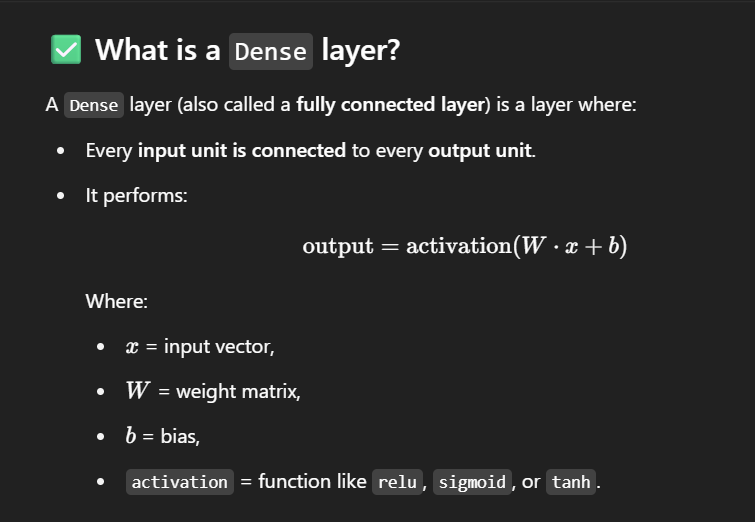
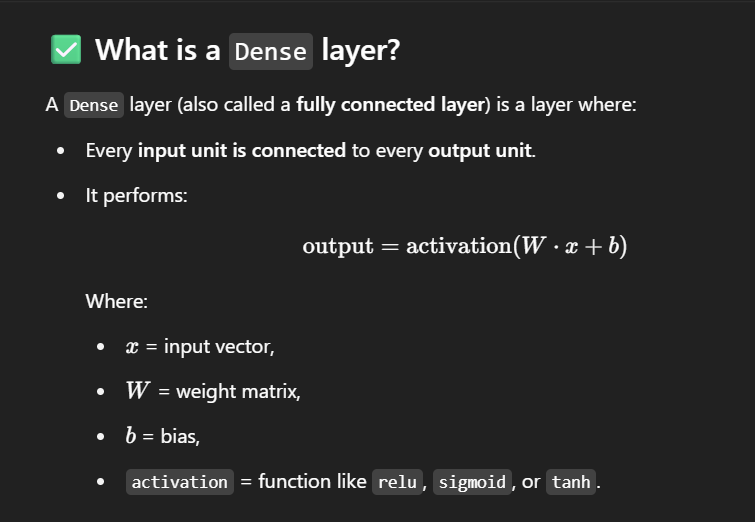
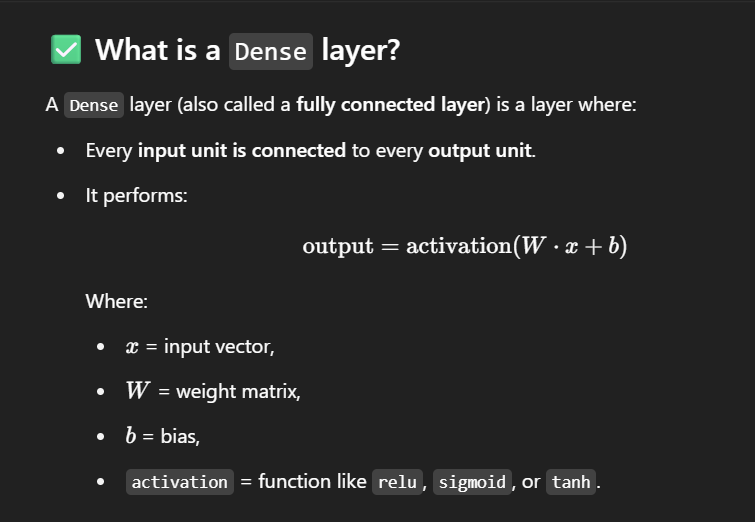

| Line               | Purpose                                        |
| ------------------ | ---------------------------------------------- |
| `Dense(7×7×128)`   | Transform noise into an initial feature vector |
| `LeakyReLU(0.2)`   | Add non-linearity & preserve gradients         |
| `Reshape(7×7×128)` | Turn it into a small image (feature map)       |


In [ ]:
def build_generator():
    model = Sequential()
    # Dense layer to project and reshape the noise
    # Takes in random values and reshapes
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))


# Purpose:
# You're transforming the noise into a dense representation 
# that will be reshaped into a low-resolution image.

#starting point for generating an image.

    #Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model
    

    





In [ ]:

generator = build_generator()

In [ ]:

generator.summary()

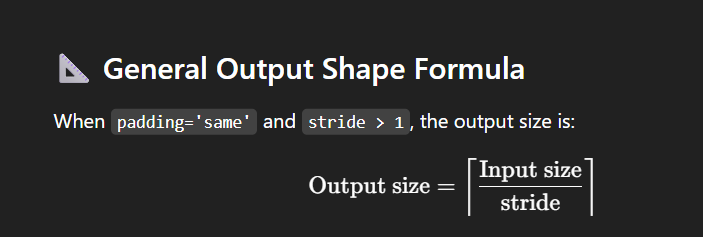

In [ ]:

img = generator.predict(np.random.randn(4,128,1))

You're generating 4 fake images using your trained Generator.

You’re passing random noise (np.random.randn) as input.

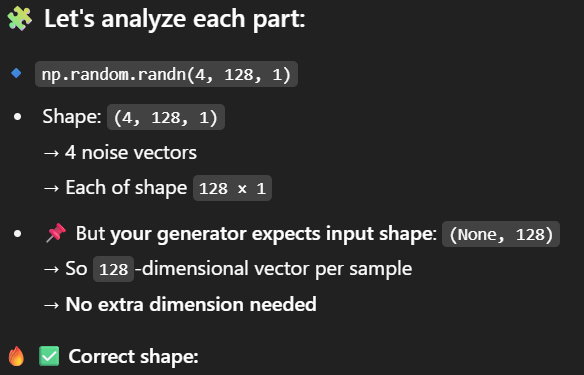

In [ ]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [ ]:

def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [ ]:

discriminator = build_discriminator()

In [ ]:

discriminator.summary()

In [ ]:
img.shape

In [ ]:

img = np.expand_dims(img, axis=0) 

In [ ]:
print(img.shape)  # (1, 28, 28, 1)


In [ ]:

discriminator.predict(img)

# 4. Construct Training Loop

### Setup Losses and Optimizers

In [ ]:
# Optimizer = Adam
# Binary Cross Entropy is loss function , it includes a sigmoid type layer within

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


In [ ]:

g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### Build Subclassed Model


In [ ]:

# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

| Feature                       | Sequential | Functional | Subclassed |
| ----------------------------- | ---------- | ---------- | ---------- |
| Easy to write                 | ✅          | ✅✅         | ❌          |
| Supports complex topology     | ❌          | ✅          | ✅✅         |
| Dynamic `call()` logic        | ❌          | ❌          | ✅✅         |
| Custom training/testing steps | ❌          | ❌          | ✅✅         |
| Model visualization (graph)   | ✅✅         | ✅✅         | ❌          |


In [ ]:
class fashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        ## create attributes for gen and disc

        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        #<!--!>##<!--!>##<!--!>##<!--!>##<!--!>#
        
        # Train the discriminator

        #<!--!>##<!--!>##<!--!>##<!--!>##<!--!>#
        
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            y_realfake = tf.clip_by_value(y_realfake, 0, 1)

            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        
        
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            ## GradientTape = A recorder for math operations, so you can compute how much one value affects another — especially the loss with respect to model weights.
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:

# Create instance of subclassed model
fashgan = fashionGAN(generator, discriminator)

In [ ]:

# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

#  Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img
from PIL import Image

class ModelMonitor(Callback):
    def __init__(self, num_img=5, latent_dim=128, save_every=100, output_dir="outputs"):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_every = save_every
        self.output_dir = output_dir

        # Create output folder if not exists
        os.makedirs(self.output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_every != 0:
            return

        # Create directory for this epoch
        epoch_dir = os.path.join(self.output_dir, f"epoch_{epoch:03d}")
        os.makedirs(epoch_dir, exist_ok=True)

        # Generate latent vectors and images
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = tf.clip_by_value(generated_images * 255, 0, 255)
        generated_images = tf.cast(generated_images, tf.uint8).numpy()

        # Save images
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(epoch_dir, f"img_{i}.png"))

        print(f"[Epoch {epoch}] Saved {self.num_img} images to {epoch_dir}")

# Example usage:
# monitor = ModelMonitor(num_img=5, latent_dim=128, save_every=100)
# gan_model.fit(dataset, epochs=2000, callbacks=[monitor])


# TRAIN

In [ ]:
hist = fashgan.fit(df, epochs=2000, callbacks=[ModelMonitor()])

# Review perfromance

In [ ]:

plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator
#### 5.1 Generate Images

In [ ]:

imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])


# Save The modeL

In [ ]:

generator.save('generator.h5')
discriminator.save('discriminator.h5')